In [3]:
%matplotlib inline

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import time

# Register ManiSkill2 environments in gym
import mani_skill2.envs

from mani_skill2.envs.pick_and_place.pick_cube import PickCubeEnv
from mani_skill2.sensors.camera import CameraConfig
from mani_skill2.utils.registration import register_env
from mani_skill2.utils.sapien_utils import look_at
from utils import get_poses_from_instructions, plot_img

# Adding segmentation

2024-02-21 13:44:22,890 - mani_skill2 - WARNING - Override registered env PickCube-MoreCamera-v0
[2024-02-21 13:44:22.892] [svulkan2] [error] GLFW error: X11: The DISPLAY environment variable is missing
[2024-02-21 13:44:22.892] [svulkan2] [warning] Continue without GLFW.


[Actor(name="ground", id="14"), Actor(name="cube", id="15"), Actor(name="goal_site", id="16")]
['panda_v2']


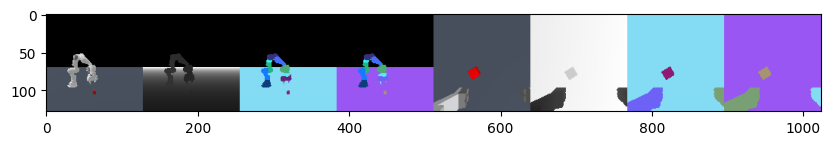

In [4]:
@register_env("PickCube-MoreCamera-v0", max_episode_steps=200, override=True)
class PickCubeMoreCameraEnv(PickCubeEnv):
    def _register_cameras(self):
        pose = look_at([1, -1, 0.5], [0, 0, 0.5])
        scene_camera = CameraConfig(
            "scene_camera", pose.p, pose.q, 128, 128, 1, 0.01, 10
        )
        return [scene_camera]

    def _register_render_cameras(self):
        return []


env = gym.make(
    "PickCube-MoreCamera-v0",
    obs_mode = "rgbd", # add +robot_seg for robot segmentation
    camera_cfgs={"add_segmentation": True},
)
obs, _ = env.reset()
print(env.get_actors())
print([x.name for x in env.get_articulations()])

plot_img(env.unwrapped.render_cameras())
env.close()
del env

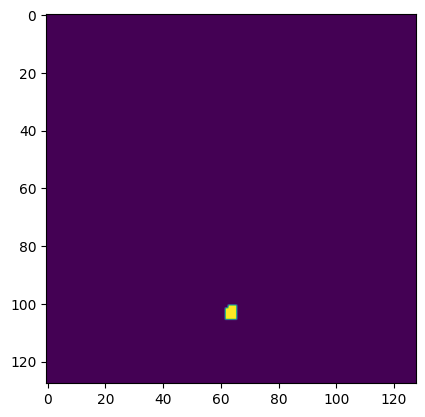

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


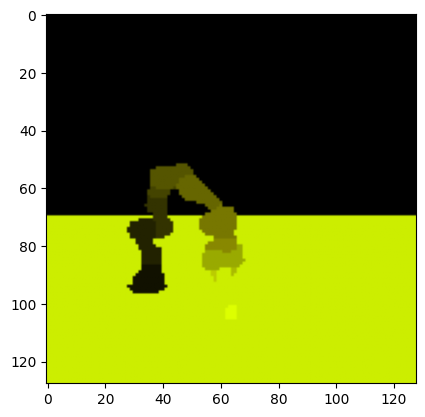

[ 0 10 11 12 13 14 15]


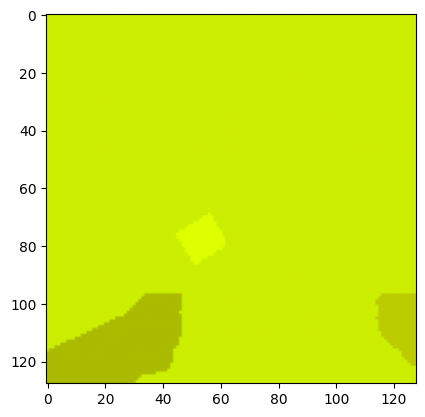

In [5]:
scene_camera = obs['image']['scene_camera']['Segmentation'][..., :3]
cube_id = 15
cube_seg = scene_camera[..., 1] == int(cube_id)
plt.imshow(cube_seg)
plt.show()

print(np.unique(scene_camera))
scene_camera = scene_camera / scene_camera.max()
plt.imshow(scene_camera)
plt.show()


hand_camera = obs['image']['hand_camera']['Segmentation'][..., :3]
print(np.unique(hand_camera))
hand_camera = hand_camera / hand_camera.max()
plt.imshow(hand_camera)
plt.show()

In [6]:
def get_obs_images(obs, idx, plot=True):
    """
        idx provides the ith camera
    """
    scene_camera = obs['image'][f'camera_{idx}']['rgb']
    seg_camera = obs['image'][f'camera_{idx}']['Segmentation'][..., :3]
    if plot:
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(scene_camera / scene_camera.max())
        axs[1].imshow(seg_camera / seg_camera.max())
        plt.show()
    return scene_camera, seg_camera

IMG_WIDTH = 1024
IMG_HEIGHT = 1024

def get_obs_from(poses, plot=True):
    """
        Get scenes and segmentation maps from different camera poses
            by creating an Environment with multiple cameras
    """
    @register_env("PickCube-MoreCamera-v0", max_episode_steps=200, override=True)
    class PickCubeMoreCameraEnv(PickCubeEnv):
        def _register_cameras(self):
            cameras = []
            for i in range(len(poses)):
                scene_camera = CameraConfig(
                    f"camera_{i}", poses[i].p, poses[i].q, IMG_WIDTH, IMG_HEIGHT, 1, 0.01, 10
                )
                cameras.append(scene_camera)
            return cameras

        def _register_render_cameras(self):
            return []

    start_time = time.time()
    env = gym.make("PickCube-MoreCamera-v0", obs_mode="rgbd", camera_cfgs={"add_segmentation": True})
    obs, _ = env.reset()
    print(f"Time to create env: {time.time() - start_time}")

    scenes = []
    segs = []

    for i in range(len(poses)):
        scene, seg = get_obs_images(obs, i, plot)
        scenes.append(scene)
        segs.append(seg)

    env.close()
    del env
    return scenes, segs

2024-02-21 13:44:29,243 - mani_skill2 - WARNING - Override registered env PickCube-MoreCamera-v0
[2024-02-21 13:44:29.244] [svulkan2] [error] GLFW error: X11: The DISPLAY environment variable is missing
[2024-02-21 13:44:29.244] [svulkan2] [warning] Continue without GLFW.


Time to create env: 15.110901832580566


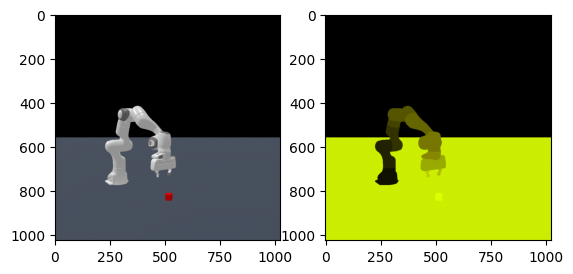

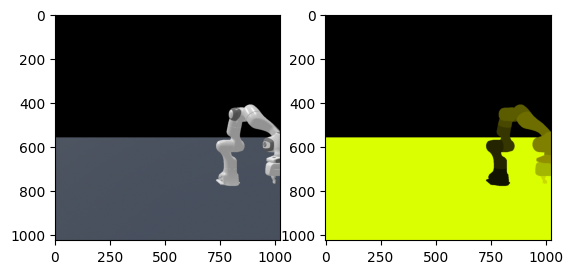

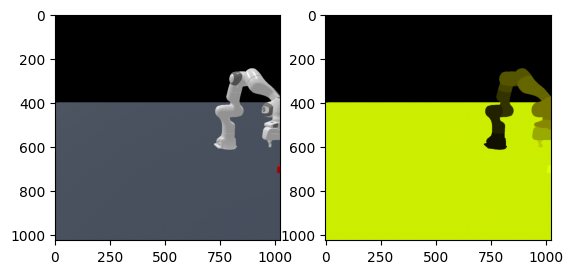

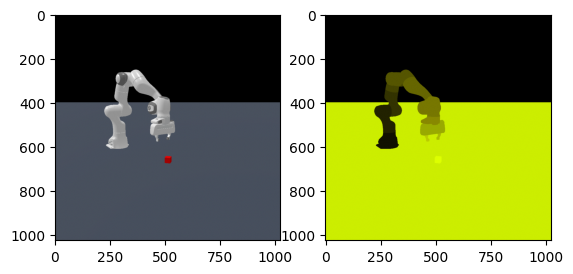

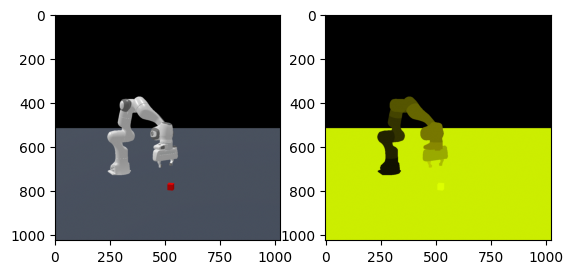

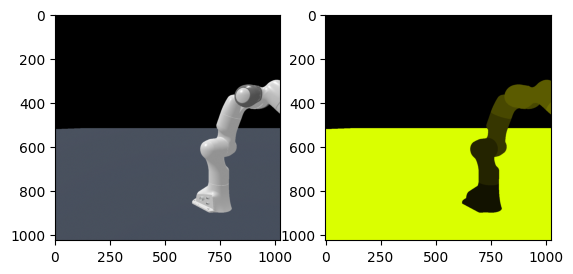

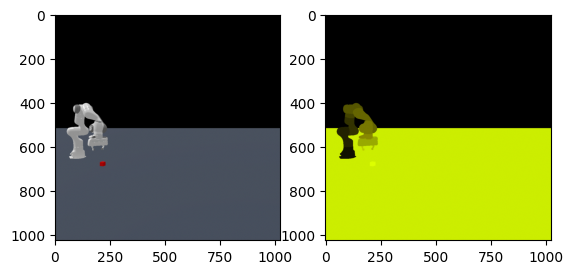

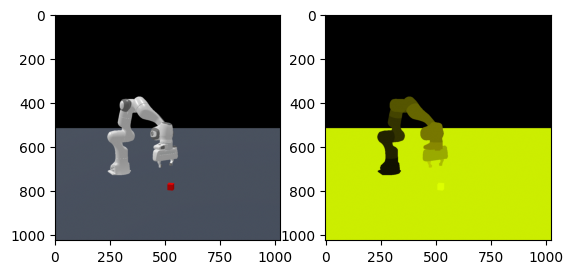

In [7]:
initial_position = [1, -1, 0.5]
initial_target = [0, 0, 0.5]

instructions = [
    ["left", "angle", 30],
    ["down", "angle", 10],
    ["right", "angle", 30],
    ["up", "angle", 10],
    ["forward", "distance", 1],
    ["backward", "distance", 2],
    ["forward", "distance", 1]
]

poses = get_poses_from_instructions(initial_position, initial_target, instructions)
scenes, segs = get_obs_from(poses, plot=True)

In [9]:
scenes = np.array(scenes)
segs = np.array(segs)

In [10]:
np.save("data/scenes.npy", scenes)
np.save("data/segs.npy", segs)